#Как создать свою RAG систему

RAG никак не влияет на веса модели, мы добавляем нашу информацию в промпт, что облегчает задачу

Да, это снижает нагрузку на наш графический процессов и мы не теряем качества, но параллельно есть другие минусы как:

- Данные реального мира беспорядочны
- Векторный поиск может быть плох, когда речь идет о разных таблицах и тому подобном.

И как же нам решить проблемы с RAG-системами?

**Улучшить качество парсера**

Хоть на LlamaHub и сеть чжже разные ридеры, которые позволяют читать разные виды данных, но в большенстве своем они работают плохо, но есть всеже разные модели, которые помогают читать данные достаточно хорошо - LlamaParse, которая преобразовывает данные из PDF файла в хороший текст для модели

Также есть сборник текстов, которые люди сами переделали в формат, который легче всего будет восприниматься моделью. Туда можно загрузить данные из разных источников, чтоб она от туда все переделала в нам нужную информацию

**Выстроить правильный chunk size**

Как правило, чтоб модель лучше воспринимала информацию, то мы должны её разбить на разные подструктуры.

Очевидным вопросом будет то, зачем мы это делаем, если мы можем закинуть абсолютно весь текст? Тут нужно понимать, что у каждой модели есть свой контекст и поэтому к середине текста модель уже будет плохо воспринимать информацию и также работает с маленьким текстом, так как контекст может быть нерелевантен, поэтому нужно уметь поиграться с разными размерами чанка для реализации.

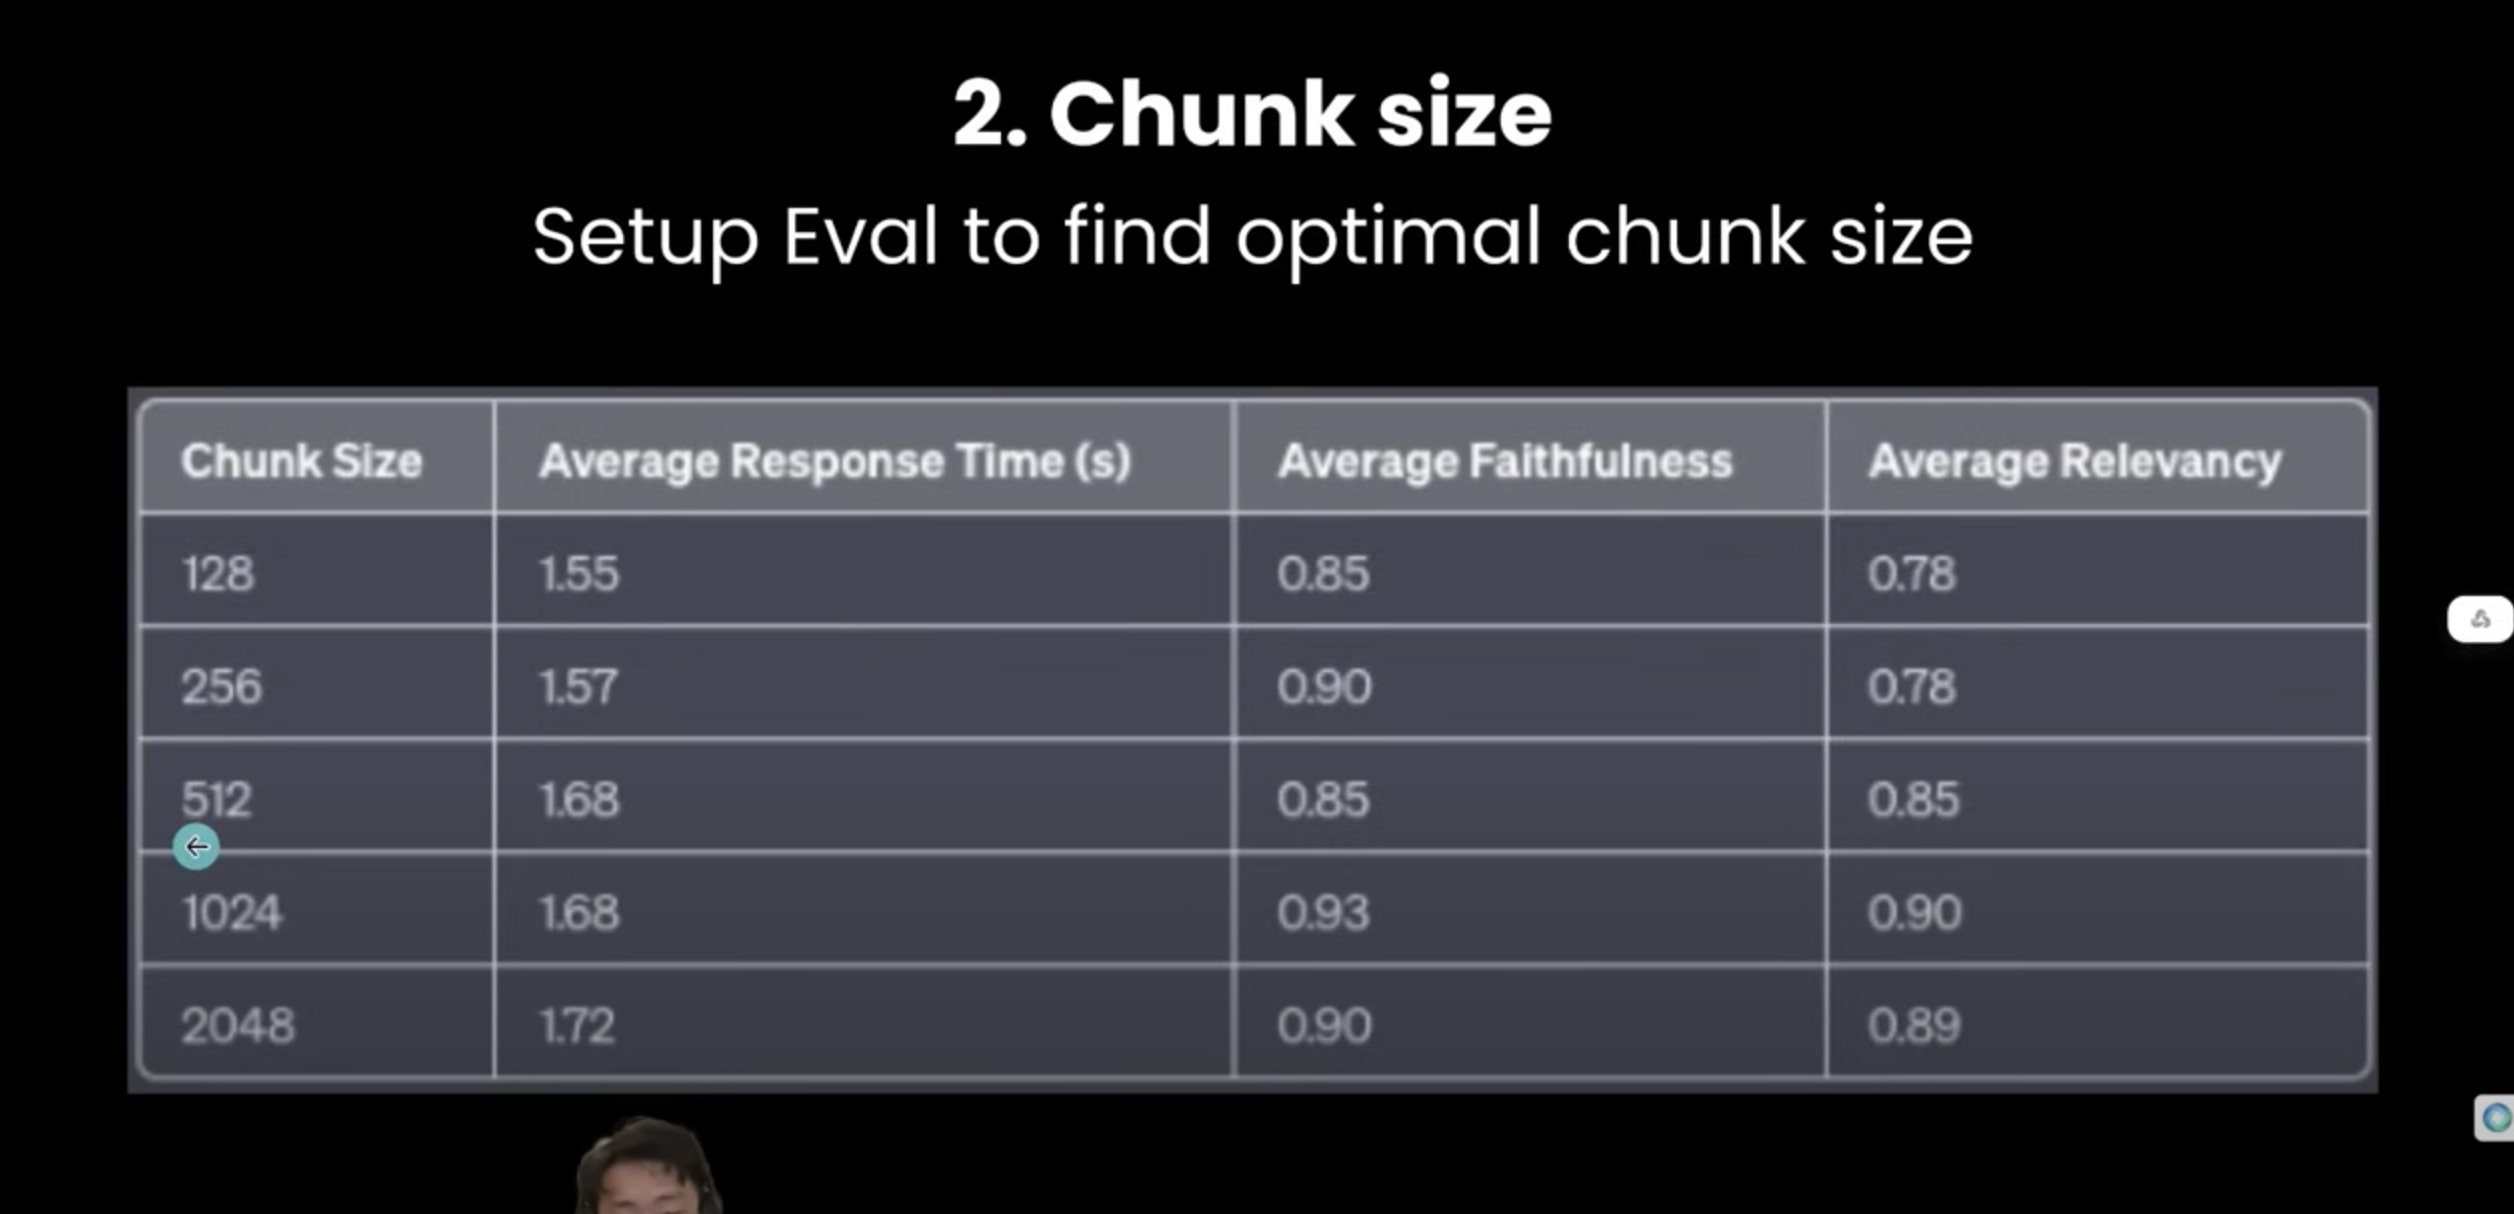

**Rerank**

Допустим для нашего вывода мы взяли размер top-k = 25, как мы знаем данный метод просто выводит верхние 25 случаев вывода, но самые релевантные среди них находятся не в самом верху, поэтому лучше использовать rerank, который сможет отранжировать данные и выбрать самые релевантные.

**Hybrid search**
Повторим, что метод веторного поиска не достаточно хорош, так как плох в контексте, поэтому есть hybrid search, который помимо векторного поиска делает поиск по ключевым словам, которые выбирают самые релевантные

**Agentic RAG**
Когда пользователь задает вопрос для модели, то очень вероятно, что по нему делать векторный поиск - неудобно, поэтому мы передаем вопрос специальному агенту, который переделывает вопрос в нужный нам формат.

Например запрос "Какие тренды продаж были основными с 2022 по 2024 год?", то агент разобьет его на 3 запроса по каждому году

И также к каждому файлу мы можем дополнить информацию о годе, стране и кратком описании, что будет крайне полезно

In [1]:
!pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all firecrawl-py

In [2]:
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'

In [3]:
%pip install --q unstructured langchain
%pip install --q "unstructured[all-docs]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install langchain_experimental

In [5]:
local_llm = 'llama3'

In [6]:
!pip install pdfminer.six

In [7]:
!pip install langchain_community

In [8]:
!python --version

Python 3.10.12


In [9]:
!pip install pdfminer.six

In [10]:
%pip install pdf2image

Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install python-poppler

  Using cached python_poppler-0.4.1.tar.gz (138 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      + meson setup C:\Users\Daniil\AppData\Local\Temp\pip-install-s0_dnc7j\python-poppler_95d22b7e7ecd4d6ba9bf6719a2576bb0 C:\Users\Daniil\AppData\Local\Temp\pip-install-s0_dnc7j\python-poppler_95d22b7e7ecd4d6ba9bf6719a2576bb0\.mesonpy-yiifjzvz -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\Daniil\AppData\Local\Temp\pip-install-s0_dnc7j\python-poppler_95d22b7e7ecd4d6ba9bf6719a2576bb0\.mesonpy-yiifjzvz\meson-python-native-file.ini
      The Meson build system
      Version: 1.4.1
      Source dir: C:\Users\Daniil\AppData\Local\Temp\pip-install-s0_dnc7j\python-poppler_95d22b7e7ecd4d6ba9bf6719a2576bb0
      Build dir: C:\Users\Daniil\AppData\Local\Temp\pip-install-s0_dnc7j\python-poppler_95d22b7e7ecd4d6ba9bf6719a2576bb0\.mesonpy-yiifjzvz
      Build type: native build
      Project name: python-poppler
      

In [12]:
# Создаем векторную базу данных

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import FireCrawlLoader,CSVLoader
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain_community.docstore.document import Document

local = ["C:/Users/Daniil/Desktop/NintendoDS-AtomicHack-2024/docs/Инструкция пользователей «D-1C1-1.22.01 Формирование графиков платежей, поступления ДС, поставок, отгрузок».pdf",
        'C:/Users/Daniil/Desktop/NintendoDS-AtomicHack-2024/docs/Отражение операций по давальческой схеме через документ «Заказ давальца»_v2.pdf']

# loader = CSVLoader(file_path = '/Users/admin/Desktop/RosAtom_final.csv').load()

#docs = [FireCrawlLoader(api_key = 'fc-8e350ad629b84f9f87d9c0cc6879fa02',url = url,mode = 'scrape').load() for url in urls] # Файловый зыгрузчик, scrape означает, что мы будем создавать сценарий для каждого url адреса
#FireCrawlLoader()
docs = [UnstructuredPDFLoader(file_path = local_path).load() for local_path in local if local_path]

docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 250,chunk_overlap = 0
)

doc_splits = text_splitter.split_documents(docs_list)

# Очистка данных от нечитабельных токенов
filtered_docs = []
for doc in doc_splits:
  if isinstance(doc,Document) and hasattr(doc,'metadata'):
    clean_metadata = {k: v for k,v in doc.metadata.items() if isinstance(v,(str,int,float,bool))}
    filtered_docs.append(Document(page_content = doc.page_content,metadata = clean_metadata))

model_name = "all-MiniLM-L6-v2.gguf2.f16.gguf"
gpt4all_kwargs = {'allow_download': 'True'}

vectorstore = Chroma.from_documents( #Создание базы данных
    documents = filtered_docs,
    collection_name = 'rag-chroma',
    embedding = GPT4AllEmbeddings(model_name = model_name,
                                  gpt4all_kwargs = gpt4all_kwargs))


retviever = vectorstore.as_retriever() # создаем поисковик для векторного поиска базы данных

In [13]:
# Теперь мы хотим понять имеет ли поисковик какое-то дело к вопросу
# поэтому мы создаем способ оченки поисковика

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model = local_llm,format = 'json',temperature = 0)

prompt = PromptTemplate(
      template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance of a retrieved document to a user question. If the document contains keywords related to the user question, grade it as relevant. It does not need to be a stingent test.
      The goal is to filter out erroneous retrievals. In Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
      In Provide the binary score as a JSON with a single key 'score' and no premable or explaination. 
      <leot_id/><|start_header_id|>user<|end_header_id|>
      Here is the retrieved document: \n\n {documents} \n\n
      Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
      """,
      input_variables = ['question','documents']
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = 'Полученные переработчиком давальческие материалы можно перемещать между складами?' # данный вопрос является актуальным, поэтому она выдаст ответ да
docs = retviever.invoke(question) # Реализуем поиск по базе данных
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({'question':question,'documents':doc_txt}))

{'score': 'yes'}


In [14]:
# Далее если вопрос явлется актуальным, то мы уже генерируем ответ

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser,StrOutputParser

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>systems<|end_header_id|> Вы являетесь помощником при выполнении заданий по поиску ответов на вопросы.
    Используйте приведенные ниже фрагменты из извлеченного контекста, чтобы ответить на вопрос. Если вы не знаете ответа, просто скажите, что вы не знаете.
    Используйте максимум три предложения и старайтесь, чтобы ответ был кратким. Напишите название файла, а не путь к нему, в котором вы нашли весь материал, и сгенерируй полный ответ на вопрос на Русском языке <|eot_id|><|start_header_id|>user<|end_header_id|>
    Вопрос: {question}
    Контекст: {context}
    Вот ответ на ваш запрос: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question","documents"])

llm = ChatOllama(model = local_llm,temperature = 0)

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()
question = 'Полученные переработчиком давальческие материалы можно перемещать между складами? Подробнее опиши сам процесс'

generation = rag_chain.invoke({'context': docs ,'question': question})
print(generation)

Ответ: Да, полученные переработчиком давальческие материалы можно перемещать между складами. Процесс заключается в электронном передаче материалов с склада в цеховую кладовую на этапе передачи материалов Заказчика, находящихся у предприятия по договору давальца.


In [15]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
  template = """ <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an answer is grounded in / supported by a set of facts.
  Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts.
  Provide the binary score as a JSON with a single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>uses<|end_header_id|>
  Here are the facts:
  \n -------- \n
  {documents}
  \n -------- \n
  Here is the answer: {generation} <|leot_id|><|start_header_id >assistant<lend_header_id|>""",
  input_variables=("generation", "documents"),
)
hallucination_grader = prompt | llm | JsonOutputParser ()
hallucination_grader.invoke({"documents": docs,"generation": generation})

{'score': 'yes'}

In [16]:
llm = ChatOllama(model = local_llm,format = 'json',temperature = 0)

prompt = PromptTemplate(
    template = """<|begin_of_text|><|start_header_id|>systems|end_header_id|> You are a grader assessing whether an answer is useful to resolve a question.
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <eot_id|><|start_header_id|>user<|end_header_id|> 
    Here is the answer:
    \n-------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({'question': question,'generation':generation})

{'score': 'yes'}

In [17]:
# Но если извлеченная информация не имеет отношения к тексту, то мы будем пробовать web search
# Что мы будем делать через Tavily AI, который помогает сделать глобальный поиск по запросу
!pip install langchain-community langchain-core

In [18]:
os.environ['TAVILY_API_KEY'] = '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'

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k = 3)

In [19]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
  """
  Тут мы создаем значения земли, то есть это те значения,
  С которыми мы хотим поделиться на различных этапах
  В нашем случае у нас будут:

  question: вопрос
  generation: вывод LLM
  web_search: вывод веб-поиска
  documents: Список документов
  """
  question: str
  generation: str
  web_search: str
  documents: List[str]

from langchain.schema import Document

def retvieve(state):
    """
    Данный узел просто нужен для обращения к базе данных
    Мы выводим документ, который содержит контекст нашего вопроса
    """
    print('Обращаемся к базе данных')
    question = state['question']
    documents = retviever.invoke(question)
    return {'documents': documents, 'question': question} # переписываем глобальное состояние

def grade_documents(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
      state (dict): The current graph state

    Returns:
      state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("--Проверка на релевантность документа--")
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    web_search = 'No'
    for d in documents:
      score = retrieval_grader.invoke({'question':question,'documents':d.page_content})
      grade = score['score']

      if grade.lower() == 'yes':
        filtered_docs.append(d)
      else:
        print('--Документ не является релевантным')
        web_search = 'Yes'
        continue
      return {'documents':filtered_docs,'question':question,'web_search':web_search}

def generate(state):
    """
    Проверяем нужно ли выполнять web поиск или сразу генерировать ответ
    """
    print('--Генерируем ответ--')
    question = state['question']
    documents = state['documents']

    generation = rag_chain.invoke({'context':documents,'question':question})
    return {'documents':documents, 'question':question, 'generation':generation}

def web_search(state):
    print('--WEB SEARCH--')
    question = state['question']
    documents = state['documents']

    docs = web_search_tool.invoke({'query':question})
    web_results = '\n'.join([d['content'] for d in docs])
    web_results = Document(page_content = web_results)
    if documents is not None:
      documents.append(web_results)
    else:
      documents = [web_results]
    return {'documents':documents, 'question': question}

def deside_to_generate(state):
      print('--Очениваем утвержденные документы--')
      question = state['question']
      web_search = state['web_search']
      filtered_documents = state['documents']

      if web_search == 'Yes':
          print('--Все документы не для вопроса явялются нерелевантными')
          return 'websearch'
      else:
          print('--Генерируем--')
          return 'generate'

def check_halluciation(state):
      print('Проверка на галлюцинации')
      question = state['question']
      documents = state['documents']
      generation = state['generation']

      score = hallucination_grader.invoke({'documents': documents,'generation':generation})
      grade = score['score']

      if grade == 'yes':
        score = answer_grader.invoke({'question': question,'generation': generation})
        grade = score['score']
        if grade == 'yes':
          return 'useful'
        else:
          return 'not useful'
      else:
        return 'not supported'


In [20]:
from langgraph.graph import StateGraph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node('websearch',web_search)
workflow.add_node('retvieve',retvieve)
workflow.add_node('grade_documents',grade_documents)
workflow.add_node('generate',generate)

workflow.set_entry_point('retvieve')
workflow.add_edge('retvieve','grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    deside_to_generate,
    {
        'websearch': 'websearch',
        'generate': 'generate'
    },
)
workflow.add_edge('websearch','generate')
workflow.add_conditional_edges(
    'generate',
    check_halluciation,
    {
        'not_supported':'generate',
        'useful': END,
        'not useful': 'websearch'
    },
)

In [21]:
app = workflow.compile()

from pprint import pprint
inputs = {'question': 'Полученные переработчиком давальческие материалы можно перемещать между складами? Подробнее опиши сам процесс'}
for out in app.stream(inputs):
    for key,value in out.items():
        pprint(f'Finished running: {key}:')
        
print(value['generation'])

Обращаемся к базе данных
'Finished running: retvieve:'
--Проверка на релевантность документа--
--Очениваем утвержденные документы--
--Генерируем--
'Finished running: grade_documents:'
--Генерируем ответ--
Проверка на галлюцинации
'Finished running: generate:'
Полученные переработчиком давальческие материалы можно перемещать между складами. Для этого используется документ "Заказ материалов в производство".


In [ ]:
workflow